# Writing out morphed water vapor products from SAPHIR
### Erfan Jahangir and Brian Mapes May 2018

Matlab codes have been used to create a set of hourly "synths" consisting of NaN-filled arrays with one orbit swath of data advected to the (hourly) target hour. 

These arrays are [241, 721) values of RH, on a half degree grid 60S-60N. 

Here we synthesize them into seamless hourly products including both RH and its Lagrangian tendency (or Analysis Terndency AT). 

---------


### General strategy of this notebook

Like any programming job, we work backward from a result-shaped container, and then forward from the most precious original data input whose value we are trying to preserve and optimize. Initially we achieve success in the simplest way, then later add sophistication -- but only to the extent it improves signal and reduces noise, as seen in the results which are fundamentally visual and thus can be evaluated smartly by eye. 

In this case, the results-shaped container is a single 1/2-degree array of 

1. **WV** (water vapor averaged over the nearest 2 times, forward and backward, from the product's nominal hour)
1. **AT** (the 'analysis tendency' of the morphing operation, representing the horizintally Lagrangian tendency in LHS terms, or more profoundly, representing the sum of all physical source-sink terms from a RHS perspective). 
1. **t_early** (the time of the earlier observation that made the above products)
1. **t_late** (the time of the later observation " " " )

------------

In [1]:
import numpy as np 
import glob             # to list available files
import scipy.io as spio # to read the .mat files
import matplotlib.pyplot as plt
import datetime
import netCDF4     # Note: python is case-sensitive!
from scipy import ndimage

In [2]:
first_hour = datetime.datetime(2012,1,1,0,0) 
last_hour  = first_hour + datetime.timedelta(days=7)

### Create the container for success: the netCDF file

In [3]:
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfile = netCDF4.Dataset('SAPHIR_morphed.nc',mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 



## Step 1: Create results-shaped containers  

In [4]:
DX = 0.5 # degrees
SOUTH = -60 # Central latitudes of southern grid  cells
NORTH = 60  # " " northern " " 
WEST = 0 # Central longitude of westernmost cell
EAST = 360 # " " easternmost " 

# Build 1D spatial coordinate arrays 
NLAT = int( (NORTH-SOUTH)/DX +1)
lat = np.linspace(SOUTH, NORTH, NLAT)

NLON = int( (EAST-WEST)/DX +1) 
lon = np.linspace(WEST, EAST, NLON) - 180.0 # Checked with independent dataset 


# Now build containers for the results we desire
# Which order? LON,LAT? or LAT,LON? The way Matlab creates the input files
# Fill with zeros 
# WV = np.zeros( (NLAT,NLON) )


In [5]:
lat_dim = ncfile.createDimension('lat', NLAT)     # latitude axis
lon_dim = ncfile.createDimension('lon', NLON)    # longitude axis
time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
for dim in ncfile.dimensions.items():
    print(dim)

('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 241
)
('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 721
)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0
)


In [6]:
ncfile.title='SAPHIR morphing data: RH and its Lagrangian rate of change'
ncfile.subtitle='Brian Mapes and Erfan Jahangir, May 2018'

# Define two variables with the same names as dimensions,
# a conventional way to define "coordinate variables".
nclat = ncfile.createVariable('lat', np.float32, ('lat',))
nclat.units = 'degrees_north'
nclat.long_name = 'latitude'
nclon = ncfile.createVariable('lon', np.float32, ('lon',))
nclon.units = 'degrees_east'
nclon.long_name = 'longitude'
nctime = ncfile.createVariable('time', np.float64, ('time',))
nctime.units = 'days since 1970-01-01'
nctime.long_name = 'time'

# Define a 3D variable to hold the data
ncRH = ncfile.createVariable('RH500',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
ncRH.units = '%' 
ncRH.standard_name = 'relative humidity composite' # this is a CF standard name

# Define a 3D variable to hold the data
ncRHp = ncfile.createVariable('RH500p',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
ncRHp.units = '%' 
ncRHp.standard_name = 'relative humidity, past obs' # this is a CF standard name

# Define a 3D variable to hold the data
ncRHf = ncfile.createVariable('RH500f',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
ncRHf.units = '%' 
ncRHf.standard_name = 'relative humidity, future obs' # this is a CF standard name

# Define a 3D variable to hold the data
ncAT = ncfile.createVariable('AT',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
ncAT.units = '% per hour' 
ncAT.standard_name = 'Lagrangian tendency of RH' 

# Define a 3D variable to hold the data
ncdtp = ncfile.createVariable('dtp',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
ncdtp.units = 'hours' 
ncdtp.standard_name = 'Time since most recent past obs' 

# Define a 3D variable to hold the data
ncdtf = ncfile.createVariable('dtf',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
ncdtf.units = 'hours' 
ncdtf.standard_name = 'Time to soonest future obs' 

In [7]:
# Write latitudes, longitudes.
# Note: the ":" is necessary in these "write" statements
nclat[:] = lat 
nclon[:] = lon 

## Step 2: The things we need to fill the containers

To fill the above arrays, we will use the *time-proximity-weighted average* for WV500:  

$ WV500 = ( WV_{before}*dt_{after} + WV_{before}*dt_{after} )/(dt_{before} + dt_{after}) $ 

and the simplest *estimate of the time derivative* using the before and after observations:

$ AT500 = ( WV_{after} - WV_{before})/(dt_{before} + dt_{after}) $ 

**Thus, we need $ WV_{before}, WV_{after}, dt_{before}, dt_{after}  $**

----------------

## How to get $ WV_{before}, WV_{after}, dt_{before}, dt_{after} $ ? 

#### We need to fill _time stacks_ of product-shaped lat-lon arrays, then process them down by compositing. 

A _time stack_ is a 3D array, NLAT x NLON x (2*DTIME+1), centered on the product time (dt=0). It doesn't matter how long in time this stack extends, as long as it is long enough that **every pixel in space has a before and an after observation**. That is, the DTMAX just has to be at least as big as the longest time gap between (advected) observations. Also, the time step between the layers in the stack (one hour) just has to be short enough that we aren't wasting observations by over-writing some locations with multiple observations, subject to efficiencies (1 minute would be overkill). Since the orbit time is about 110 minutes, DTIME=19 and 1-hour stacks are chosen. 

# Fill containers, for a set of product hours

### At each hour, 

1. **Process a set of files** to get $ WV_{before}, WV_{after}, dt_{before}, dt_{after} $.
1. **Combine before and after into products** 

-----
# FUTURE (backward advected) and PAST (forward advected) 
## Define the functions to build each estimate
------

In [8]:
def update_future_composite(futurefiles_wildcard, WV_future, minobtime): 
     
# Before calling for the first time, build these arrays like this 
# Make lat x lon containers full of NaN for the WV and minimum ob time
#    WV_future = np.zeros( (NLAT,NLON) ); WV_future.fill(np.nan)
#    minobtime = np.zeros( (NLAT,NLON) ) + 9.99e19 # huge so any obs time will be less
    
    
# Loop over files, updating arrays wherever the obtime is smaller than the existing value
#    print(np.size(glob.glob(futurefiles_wildcard)), ' files in future')
    for idx,filename in enumerate(glob.iglob(futurefiles_wildcard), start=0):
        mat = spio.loadmat(filename, squeeze_me=True, struct_as_record=False)
        
# Extract the "synth" data and time arrays, and set -999 values to NaN
        synth = mat['synth']
        data = synth.gridded        
        data [data < 0] = np.nan
        obtime = synth.sourcetime + data*0  # this will propagate the nan values
                
# Grab the areas that are useful (that is, are the least-far in the future)
        useful = obtime < minobtime ### Ignore warings from comparing NaN to numbers. 
        WV_future[useful] = data  [useful]
        minobtime[useful] = obtime[useful]
        
    return(WV_future, minobtime + WV_future*0) # NAN mask for minobtime

In [9]:
def update_past_composite(pastfiles_wildcard, WV_past, maxobtime): 
     
# Before calling for the first time, build these arrays like this 
# Make lat x lon containers full of NaN for the WV and maximum ob time
#    WV_past   = np.zeros( (NLAT,NLON) ); WV_past.fill(np.nan)
#    maxobtime = np.zeros( (NLAT,NLON) )  # zero so any obs time will be greater
    
# Loop over files, updating arrays wherever the obtime is greater than the existing value
#    print(np.size(glob.glob(pastfiles_wildcard)), ' files in past')
    for idx,filename in enumerate(glob.iglob(pastfiles_wildcard), start=0):
        mat = spio.loadmat(filename, squeeze_me=True, struct_as_record=False)
        
# Extract the "synth" data and time arrays, and set -999 values to NaN
        synth = mat['synth']
        data = synth.gridded        
        data [data < 0] = np.nan
        obtime = synth.sourcetime + data*0  # this will propagate the nan values
        
# Grab the areas that are useful (that is, are the least-far in the future)
        useful = obtime > maxobtime   ### Ignore warings from comparing NaN to numbers. 
        WV_past[useful]   = data  [useful]
        maxobtime[useful] = obtime[useful]
        
    return(WV_past, maxobtime + WV_past*0) # NaN mask for maxobtime

-------------
# Build future and past obs, relative to product hour
## works from files in arbitrary order
-------------

## Writing data

To write data a netCDF variable object, just treat it like a numpy array and assign values to a slice.

------------
# Set first and last times of hourly product loop:
------------

In [10]:
nctime.units = 'hours since 2012-01-01'

#first_hour = datetime.datetime(2012,1,1,0,0) 
#last_hour  = first_hour + datetime.timedelta(days=7)

print(first_hour.strftime('%Y%m%dT%H'), last_hour.strftime('%Y%m%dT%H'))
nhours = (last_hour-first_hour).days*24. + (last_hour-first_hour).seconds/3600.
print( nhours, ' hours' )

20120101T00 20120108T00
168.0  hours


In [11]:
# Loop over time and build the 3D result array 

for ihour in range(int(nhours)):
    now = first_hour + datetime.timedelta(hours=ihour)
    prodtime = now - datetime.datetime(1970, 1, 1) 

## Future data (which has been "backward" advected) 
    futurefiles_wildcard = '../SAPHIR-morphing-data-201201_7days/Synths/*backward*' + now.strftime('%Y%m%dT%H') +'*mat'
#    print('FUTURE: ', glob.glob(futurefiles_wildcard) )
## Past data (which has been "forward" advected) 
    pastfiles_wildcard = '../SAPHIR-morphing-data-201201_7days/Synths/*forward*' + now.strftime('%Y%m%dT%H') +'*mat'
#    print('PAST: ', glob.glob(pastfiles_wildcard) )
    
### FUTURE array update
    WV_future = np.zeros( (NLAT,NLON) )
    WV_future.fill(np.nan)
    minobtime = np.zeros( (NLAT,NLON) ) + 9.99e19 # huge so any obs time will be less
    WV_future, minobtime = update_future_composite(futurefiles_wildcard, WV_future, minobtime)

### update PAST arrays
    WV_past = np.zeros( (NLAT,NLON) ); WV_past.fill(np.nan)
    maxobtime = np.zeros( (NLAT,NLON) ) - 999. # negative, so any obs time will be greater
    WV_past, maxobtime = update_past_composite(pastfiles_wildcard, WV_past, maxobtime)


# Combine future and past using the two observation times (in hours)
## 2. Weighted sum: WV
## 1. d/dt, called AT (Analysis Tendency)

    past_offset   = 24*abs(maxobtime - prodtime.days - prodtime.seconds/3600./24.)
    future_offset = 24*abs(minobtime - prodtime.days - prodtime.seconds/3600./24.)

# Median filter to remove speckle
    MEDIAN_AREA = 4

    WVf_filt = ndimage.median_filter(WV_future, MEDIAN_AREA)
    WVp_filt = ndimage.median_filter(WV_past, MEDIAN_AREA)

# Filter the time offset variable: past, filling gaps with 24h
    poff = past_offset 
    poff[np.isnan(poff)] = 24
    poff_filt = ndimage.median_filter(poff, MEDIAN_AREA)

# Filter the time offset variable: future, filling gaps with 24h
    foff = future_offset 
    foff[np.isnan(foff)] = 24
    foff_filt = ndimage.median_filter(foff, MEDIAN_AREA)

    
## 2. Weighted sum: WV
## 1. d/dt, called AT (Analysis Tendency)

# AT is the derivative: 
# experience shows it is too big where denominator is small
# is there a slight dt error? Just enforce a minimum of 6h.
    dt = (poff_filt + foff_filt)
    dt[dt < 6]=6 # 6 hours minimum for the denominator
# AT is the derivative
    AT = (WVf_filt - WVp_filt)/dt

# Proximity-weighted average of the two estimates
    WV = (WVf_filt*poff_filt + WVf_filt*foff_filt)/(poff_filt + foff_filt)

# Fill in the gaps where one or the other estimate (future or past) is NaN (missing) 
    WV[np.isnan(WVf_filt)] = WVp_filt [np.isnan(WVf_filt)]
    WV[np.isnan(WVp_filt)] = WVf_filt [np.isnan(WVp_filt)]

    
# Send the data to the netCDF file
    ncRH [ihour,:,:] = WV
    ncRHp[ihour,:,:] = WVp_filt
    ncRHf[ihour,:,:] = WVf_filt
    ncAT [ihour,:,:] = AT
    ncdtp[ihour,:,:] = poff_filt
    ncdtf[ihour,:,:] = foff_filt
    nctime[ihour] = ihour

//anaconda/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
//anaconda/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
//anaconda/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
//anaconda/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


## Closing netCDF file
- flushes buffers to make sure all data gets written

In [12]:
# first print the Dataset object to see what we've got
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: SAPHIR morphing data: RH and its Lagrangian rate of change
    subtitle: Brian Mapes and Erfan Jahangir, May 2018
    dimensions(sizes): lat(241), lon(721), time(168)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 time(time), float64 RH500(time,lat,lon), float64 RH500p(time,lat,lon), float64 RH500f(time,lat,lon), float64 AT(time,lat,lon), float64 dtp(time,lat,lon), float64 dtf(time,lat,lon)
    groups: 

Dataset is closed!


Text(0.5,1,'Time rate of change (Lagrangian) %/hour')

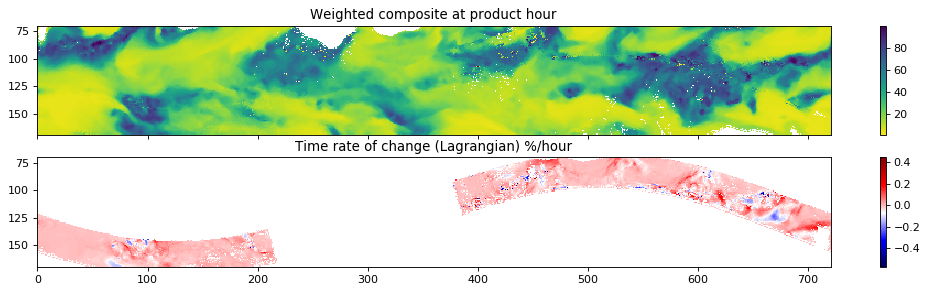

In [13]:
%matplotlib inline

### Display last hour as a test
fig, axarr = plt.subplots(2, sharex=True, figsize=(16, 4), dpi=80)

# WV
WVim = axarr[0].imshow(WV, cmap='viridis_r')
fig.colorbar(WVim, ax=axarr[0])
axarr[0].set_title('Weighted composite at product hour')

# time           
ATim = axarr[1].imshow(AT/24., cmap='seismic')
fig.colorbar(ATim, ax=axarr[1])
axarr[1].set_title('Time rate of change (Lagrangian) %/hour')


# Capture images from IDV session displaying the results

In [14]:
%load_ext drilsdown

VBox(children=(HTML(value='<h3>iPython-IDV Control Panel</h3>'), HBox(children=(HTML(value='<b>Resources:</b>'), Dropdown(options={'The Mapes IDV Collection': '45e3b50b-dbe2-408b-a6c2-2c009749cd53', 'Geode Systems Drilsdown Collection': '12704a38-9a06-4989-aac4-dafbbe13a675', 'NOAA-ESRL-PSD Climate Data Repository': 'f8d470f4-a072-4c1e-809e-d6116a393818', 'Unidata THREDDS Data Server': 'http://thredds.ucar.edu/thredds/catalog.xml', 'Unidata RAMADDA Server': '0', 'University of Miami THREDDS Data Server': 'http://weather.rsmas.miami.edu/thredds/catalog.xml', 'Local Files': '.'}, value='45e3b50b-dbe2-408b-a6c2-2c009749cd53'), Button(description='List', style=ButtonStyle(), tooltip='List'))), HBox(children=(HTML(value='<b>Search for:</b>'), Text(value='', layout=Layout(width='150px'), placeholder='IDV bundle'), Text(value='', layout=Layout(width='150px'), placeholder='Case Study or folder'), Text(value='', layout=Layout(width='150px'), placeholder='Gridded data files'), Text(value='', layout=Layout(width='150px'), placeholder='All'))), HBox(children=(Button(description='Run IDV', style=ButtonStyle(), tooltip='Run IDV'), Button(description='Make Image', style=ButtonStyle(), tooltip='Make Image'), Button(description='Make Movie', style=ButtonStyle(), tooltip='Make Movie'), Button(description='Save Bundle', style=ButtonStyle(), tooltip='Save Bundle'), Checkbox(value=False, description='Publish'))), HBox(children=(Button(description='Clear Outputs', style=ButtonStyle(), tooltip='Clear Outputs'), Button(description='Commands Help', style=ButtonStyle(), tooltip='Commands Help'), Label(value='')))))

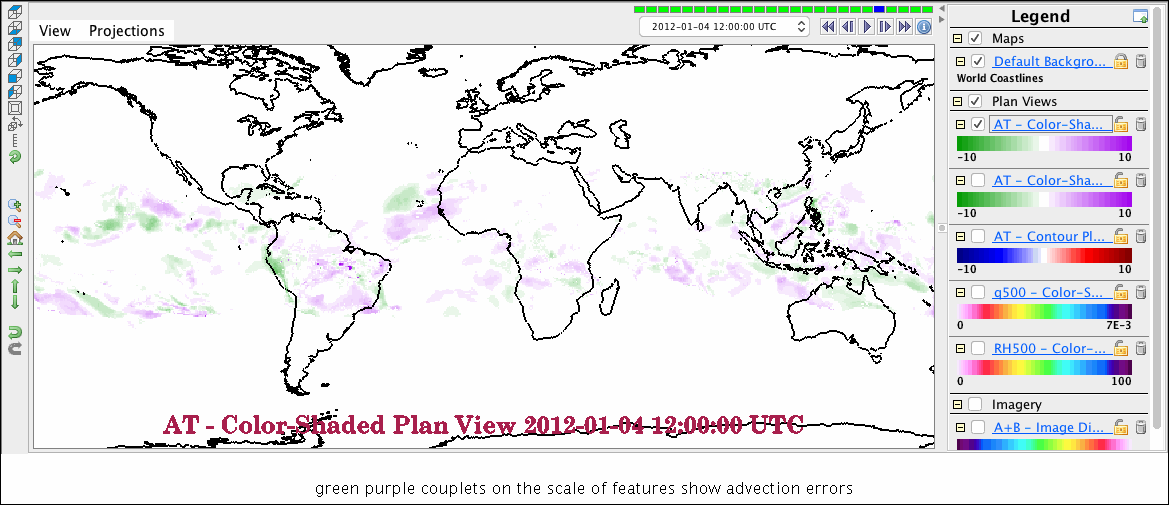

In [19]:
%make_image -capture legend -caption 'green-purple couplets on the scale of features show advection errors'

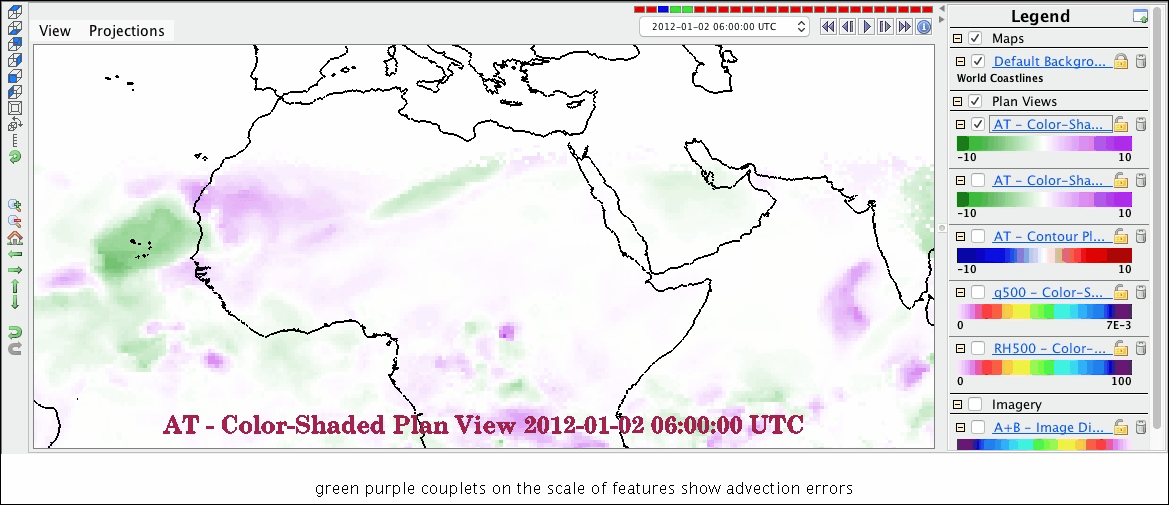

In [21]:
%make_movie -capture legend -caption 'green-purple couplets on the scale of features show advection errors'

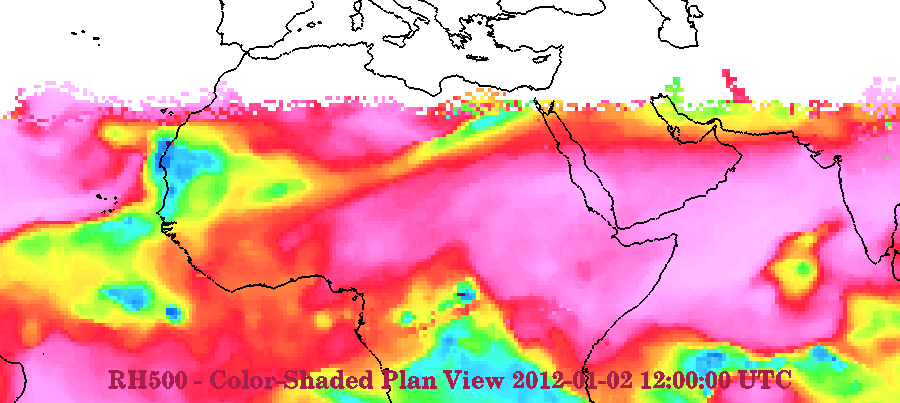

In [22]:
%make_image

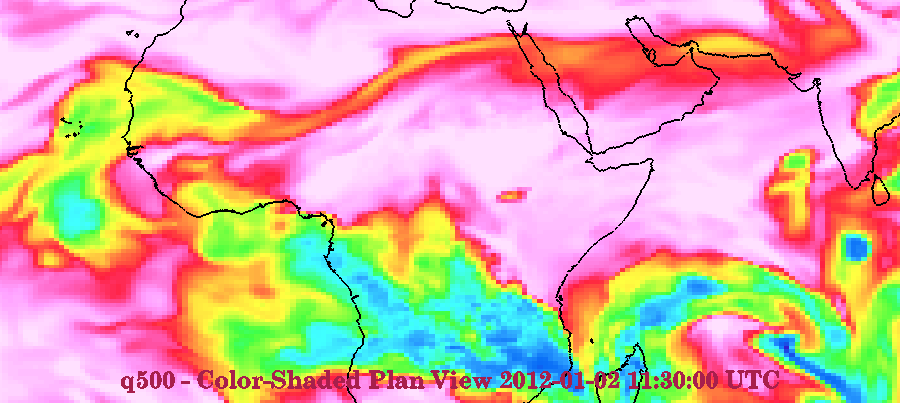

In [23]:
%make_image